**сеть Хемминга**

Евгений Борисов <esborisov@sevsu.ru>

Борисов Е.  Классификатор на основе нейронной сети Хемминга.   
http://mechanoid.su/neural-net-hamming-classifier.html

##  загружаем данные 

In [1]:
# !ls data

In [2]:
import pickle
import gzip

with gzip.open('data/numb-30x30.pkl.gz','rb') as f: data = pickle.load(f)

In [3]:
data_train = data['train']['data']
data_test_0 = data['test']['noise_lo']['data']
data_test_1 = data['test']['noise_hi']['data']
data_test_2 = data['test']['shift']['data']
data_test_3 = data['test']['shift_noise_lo']['data']

del data

In [4]:
import matplotlib.pyplot as plt

def plot_images(data,figsize=(10,4)):
    fig, ax = plt.subplots(1,len(data), figsize=figsize)
    for i in range(len(data)): 
        ax[i].axis('off')
        ax[i].imshow(data[i]) #,cmap='GnBu')

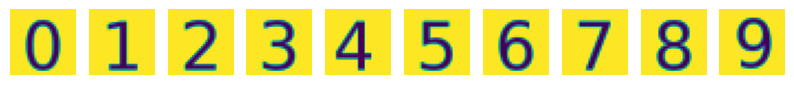

In [5]:
plot_images(data_train,(len(data_train),2))

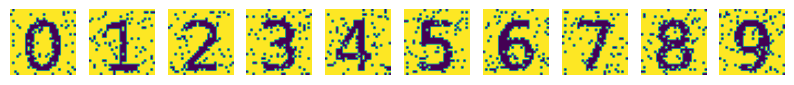

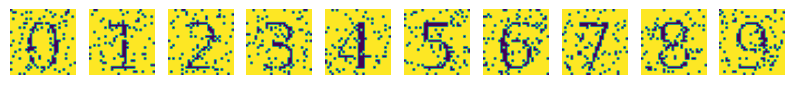

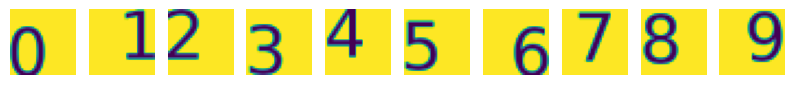

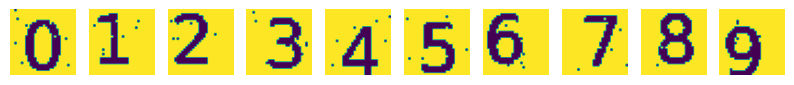

In [6]:
plot_images(data_test_0, (len(data_test_0), 2))
plot_images(data_test_1, (len(data_test_1), 2))
plot_images(data_test_2, (len(data_test_2), 2))
plot_images(data_test_3, (len(data_test_3), 2))

In [7]:
# data_test_3

## формируем датасет

In [8]:
import numpy as np
from numpy import random as rng

In [9]:
n,w,h = data_train.shape
x_train = np.sign( 254.-data_train ).reshape(n,w*h)

n,w,h = data_test_0.shape
x_test_0 = np.sign( 254.-data_test_0 ).reshape(n,w*h)

n,w,h = data_test_1.shape
x_test_1 = np.sign( 254.-data_test_1 ).reshape(n,w*h)

n,w,h = data_test_2.shape
x_test_2 = np.sign( 254.-data_test_2 ).reshape(n,w*h)

n,w,h = data_test_3.shape
x_test_3 = np.sign( 254.-data_test_3 ).reshape(n,w*h)

display(( x_train.shape, x_test_0.shape, x_test_1.shape, x_test_2.shape, x_test_3.shape ))

((10, 900), (10, 900), (10, 900), (10, 900), (10, 900))

In [10]:
# x_test_0

# модель

![boltzman](http://mechanoid.su/content/neural-net-hamming-classifier.html/nnet.png)

In [11]:
class HammingNet:
    
    def __init__(self):
        self._weight_lin = 0.
        self._weight_hop = 0.
        
    def fit(self,x):
        self._weight_lin = x.T/2.
        
        n_samples,_ = x.shape # количество учебных примеров 
        c = 1./(2.*n_samples) # коэффициент торможения
        # веса для нейронов второго слоя
        self._weight_hop = -c*(np.ones(n_samples)-np.eye(n_samples)) + np.eye(n_samples)
        
        return self
    
    def forward(self,x,max_iter=6):
        o = x.dot(self._weight_lin)
        for n in range(max_iter):
            o_ = o.copy() # сохраняем состояние
            o = self._forward_step(o) # переходим в новое состояние
            # если состояние не изменилось то завершаем
            if np.all(o==o_): break
        return n,o        
    
    def _forward_step(self,x):
        return np.max( [x.dot(self._weight_hop), np.zeros(x.shape)],axis=0 )
    
    def __call__(self,x):
        return self.forward(x)
    
    def predict(self,x):
        n,o = self.forward(x)
        return n,np.argmax(o,axis=1)

# загружаем память модели

In [12]:
model = HammingNet().fit(x_train)

# тестируем

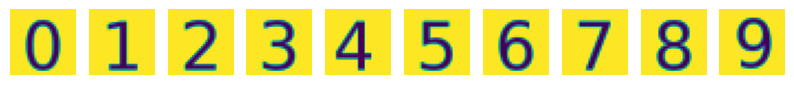

In [13]:
plot_images(data_train,(len(data_train),2))

(5, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0]))

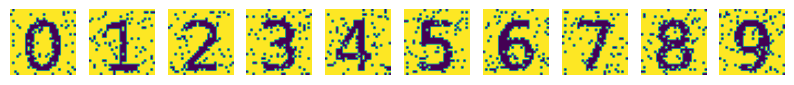

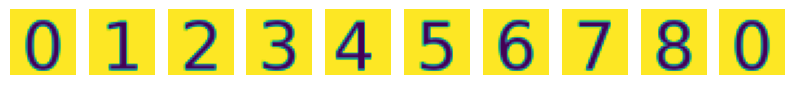

In [14]:
# средне зашумлённые
n,p = model.predict(x_test_0)
display((n,p))
plot_images(data_test_0, (len(data_test_0), 2))
plot_images(data_train[p], (len(data_test_0), 2))

In [15]:
# p

(5, array([0, 1, 2, 3, 4, 5, 6, 7, 3, 1]))

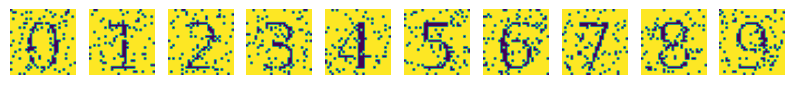

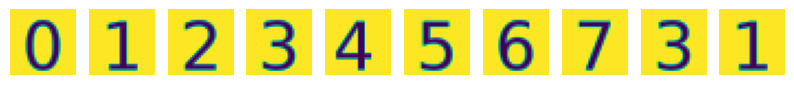

In [16]:
# сильно зашумлённые
n,p = model.predict(x_test_1)
display((n,p))
plot_images(data_test_1, (len(data_test_1), 2))
plot_images(data_train[p], (len(data_test_1), 2))

(5, array([1, 1, 4, 1, 4, 7, 1, 7, 4, 1]))

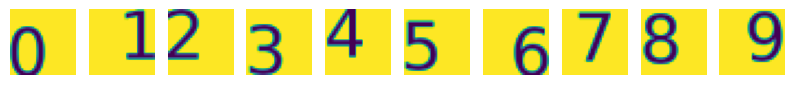

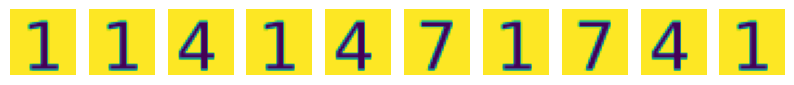

In [17]:
# искажение сдвигом
n,p = model.predict(x_test_2)
display((n,p))
plot_images(data_test_2, (len(data_test_2), 2))
plot_images(data_train[p], (len(data_test_2), 2))

(5, array([0, 4, 4, 9, 3, 5, 4, 7, 9, 4]))

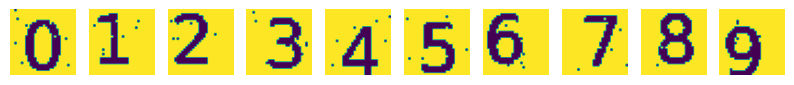

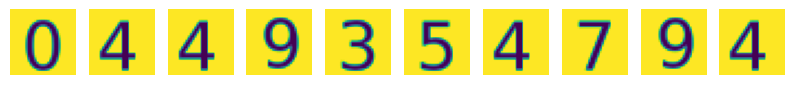

In [18]:
# искажение сдвигом
n,p = model.predict(x_test_3)
display((n,p))
plot_images(data_test_3, (len(data_test_3), 2))
plot_images(data_train[p], (len(data_test_3), 2))